In [120]:
from dotenv import load_dotenv
import os
from typing import Dict, List, Optional

In [121]:
load_dotenv()
ALPHA_VANTAGE_API_KEY= os.environ.get("ALPHA_VANTAGE_KEY") # Uses free version API key
EODHD_API_KEY = os.environ.get("EODHD_API_KEY")

## This notebook will focus mainly on the following parts:

<ol>
    <li>Create a Ticker class that represents a ticker, retrieves daily prices, and computes common indicators such as EMAs, MACD, signal lines, and RSI.</li>
    <li>Plot the prices and EMAs for analysis, as well as the MACD versus signal line, and the RSI.</li>
    <li>Develop a stochastic model class based on data and chart analysis.</li>
    <li>Run multiple Monte Carlo simulations using the stochastic model and perform a final analysis.</li>
</ol>


### 1. Create a Ticker class that represents a ticker, retrieves daily prices, and computes common indicators

In [253]:
class Ticker():
    """A class that represents a ticker symbol."""
    
    def __init__(self, ticker: str, api_key: str, period: str = "daily"):

        if period != "daily":
            raise ValueError("The ticker class currently only supports daily periods!")
            
        self.ticker = ticker.upper()
        self.api_key = api_key
        self.period = period
        self.data_dict = None
        self.no_periods = None
        self.ema_dict = None
        self.ema_history = None
        self.periods = [10, 12, 20, 26, 50, 200]

        

    def get_daily_data(self):
        """Get the JSON that represents the daily stock price for the ticker / symbol of the class."""

        if self.data_dict != None:
            return self.data_dict
        import requests
        
        # i would have used the adjusted daily price instead, but im broke n am using the free API
        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={self.ticker}&outputsize=full&apikey={self.api_key}'
        r = requests.get(url)
        self.data_dict = r.json()
        self.no_periods = len(self.data_dict['Time Series (Daily)'].keys())
        return r.json()


    def __calculate_ema(self, time_period: int, closing_price: float, previous_ema = 0, use_previous_ema_arg = False):
        """Return the EMA of the given ticker and a window for the EMA. The data_dict is to find the EMA up to a certain given date.
            The code assumes that the data_dict is sorted from newest to oldest for data manipulation.
        """

        if not use_previous_ema_arg:
        
            previous_ema = self.ema_dict[f"ema_{time_period}"]
        
        alpha = 2 / (time_period + 1)
        ema = alpha * closing_price + (1 - alpha) * previous_ema
        
        return ema

    def __update_ema(self, time_period: int, new_ema: int):
        
        self.ema_dict[f"ema_{time_period}"] = new_ema
        self.ema_history[f"ema_{time_period}"].append(new_ema)

    def get_macd(self):
        "Get the MACD of the current symbol"
        
        return [ema_12 - ema_26 for ema_12, ema_26 in zip(self.ema_history["ema_12"], self.ema_history["ema_26"])]

    def get_signal_line(self):

        macd_list = self.get_macd()
        signal_line_history = []
        ema = 0

        for macd in macd_list:
            ema = self.__calculate_ema(9, macd, ema, use_previous_ema_arg = True)
            signal_line_history.append(ema)
            
        return signal_line_history
        

    def get_ema(self):

        if self.data_dict == None:
            self.get_daily_data()

        closing_prices = [self.data_dict['Time Series (Daily)'][day]['4. close'] for day in tuple(self.data_dict['Time Series (Daily)'].keys())]
        
        closing_prices = list(map(float, closing_prices))
        
        assert len(closing_prices) == self.no_periods, "Closing prices length does not match number of periods!"

        oldest_price = closing_prices[-1]
        
        self.ema_dict = {
            "ema_10": oldest_price,
            "ema_12": oldest_price,
            "ema_20": oldest_price,
            "ema_26": oldest_price,
            "ema_50": oldest_price,
            "ema_200": oldest_price
        }
        self.ema_history = {
            "ema_10": [],
            "ema_12": [],
            "ema_20": [],
            "ema_26": [],
            "ema_50": [],
            "ema_200": []
            
        }


        for closing_price in closing_prices[::-1]:
            for period in self.periods:
                ema = self.__calculate_ema(period, closing_price)
                self.__update_ema(period, ema)
                
        return self.ema_history

    def get_rsi(self):

        closing_prices = [self.data_dict['Time Series (Daily)'][day]['4. close'] for day in tuple(self.data_dict['Time Series (Daily)'].keys())]
        closing_prices = list(map(float, closing_prices))[::-1]

        price_diff_list = [ closing_prices[i] - closing_prices[i - 1] for i in range(1, len(closing_prices))]
        price_diff_list.insert(0, 0) # To match original closing_price length

        RSI_WINDOW_SIZE = 14 #DEFAULT RSI WINDOW MEASURE
        EPSILON = 1e-6 # In case the avg negative gain is zero (shouldnt happen but just in case)
        
        window = RSI_WINDOW_SIZE

        rsi_list = [0] * (RSI_WINDOW_SIZE - 1) # First 13 days will not have an RSI measure
        
        while window <= len(price_diff_list):
            
            window_diff = price_diff_list[window - RSI_WINDOW_SIZE: window]
            positive_gains = list(filter(lambda x: x >= 0, window_diff))
            negative_gains = list(filter(lambda x: x <= 0, window_diff))
            negative_gains_abs = list(map(lambda x: abs(x), negative_gains))
            
            avg_positive_gain = sum(positive_gains) / len(positive_gains)
            avg_negative_gain = sum(negative_gains_abs) / len(negative_gains)

            rsi_list.append(100 - (100 / (1 + avg_positive_gain / (avg_negative_gain + EPSILON))))

            window += 1
            
        return rsi_list
    
        
        

In [254]:
#Set ticker symbol

aapl_ticker = Ticker(ticker = "aapl", api_key = ALPHA_VANTAGE_API_KEY)

In [255]:
ema_history = aapl_ticker.get_ema()
macd_list = aapl_ticker.get_macd()
signal_line_history = aapl_ticker.get_signal_line()
rsi_list = aapl_ticker.get_rsi()

## 2. Plot the prices and EMAs for analysis, as well as the MACD versus signal line, and the RSI.

In [264]:
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime


def convert_to_datetime(date_list):
    
    return [datetime.strptime(d, "%Y-%m-%d") for d in date_list]

def get_last_n(data_list, no_years, stock_days_per_year = 252, newest_first = False):

    no_elems = int(no_years * stock_days_per_year)
    data_list = data_list[:no_elems]

    if newest_first:
        return data_list

    return data_list[::-1]
    

def draw_symbol_price_history(ticker_obj, ema_history: dict, macd_list: list, signal_line: list, rsi_list: list):

    #Get object data
    ticker_data = ticker_obj.data_dict
    ticker_name = ticker_obj.ticker

    #Set up parameters and plt
    LAST_N_YEARS = 4.5
    
    fig, (ax, ax1, ax2) = plt.subplots(nrows = 3, figsize = (30, 18))

    #Set up data
    full_dates = list(ticker_data['Time Series (Daily)'].keys())
    dates = get_last_n(list(ticker_data['Time Series (Daily)'].keys()), LAST_N_YEARS)
    
    closing_prices = get_last_n([ticker_data['Time Series (Daily)'][day]['4. close'] for day in full_dates], LAST_N_YEARS)
    closing_prices = list(map(float, closing_prices))

    dates = convert_to_datetime(dates)

    #Set up Y-axis ticks
    min_price = int(min(closing_prices) / 5) * 5
    max_price = int(max(closing_prices) / 5 + 1) * 5
    y_ticks = np.arange(min_price, max_price, 10)

    #Date ticks to be month by month

    ax.tick_params(axis = "y", labelrotation = 30)
    ax.tick_params(axis = "x", labelrotation = 30)
    
    ax.set_yticks(y_ticks)

    #Plot the data
    ax.plot(dates, closing_prices, color = 'blue', label = 'price')
    ax.fill_between(dates, closing_prices, min_price, color = 'lightblue', alpha = 0.5)    

    #Plot information
    ax.set_ylabel("Stock Price in USD")
    ax.set_title(f"{ticker_name} PRICE OVER THE LAST {LAST_N_YEARS} YEARS IN USD")
    #=======================================================================================

    filtered_periods = list(filter(lambda x : x not in [9, 12, 26], ticker_obj.periods))

    colors = ["yellow", "red", "blue", "purple"]

    #Plot EMA data
    
    for i, period in enumerate(filtered_periods):
        if period not in [9, 12, 26]: #These periods were used for MACD analysis only
            ema_data = get_last_n(ema_history[f"ema_{period}"][::-1], LAST_N_YEARS)
            ax.plot(dates, ema_data, label = f"ema_{period}", color = colors[i])
        
    ax.legend()

    #=======================================================================================

    #Plot MACD data on another figure
    macd_list = get_last_n(macd_list, LAST_N_YEARS)
    ax1.plot(dates, macd_list, color = 'yellow', label = 'macd_line')

    signal_line = get_last_n(signal_line, LAST_N_YEARS)
    ax1.plot(dates, signal_line, color = 'purple', label = 'signal_line')
    ax1.legend()
    ax1.set_ylabel("MACD vs Signal Line Graph")

    #========================================================================================

    #Plot RSI on the last figure

    rsi_list = get_last_n(rsi_list[::-1], LAST_N_YEARS)
    ax2.plot(dates, rsi_list, label = "RSI Indicator", color = "orange")
    ax2.fill_between(dates, rsi_list, 0, color = "#FFC966")
    ax2.legend()
    ax2.set_ylabel("RSI Indicator in (%)")
    ax2.set_xlabel("DATE")

     

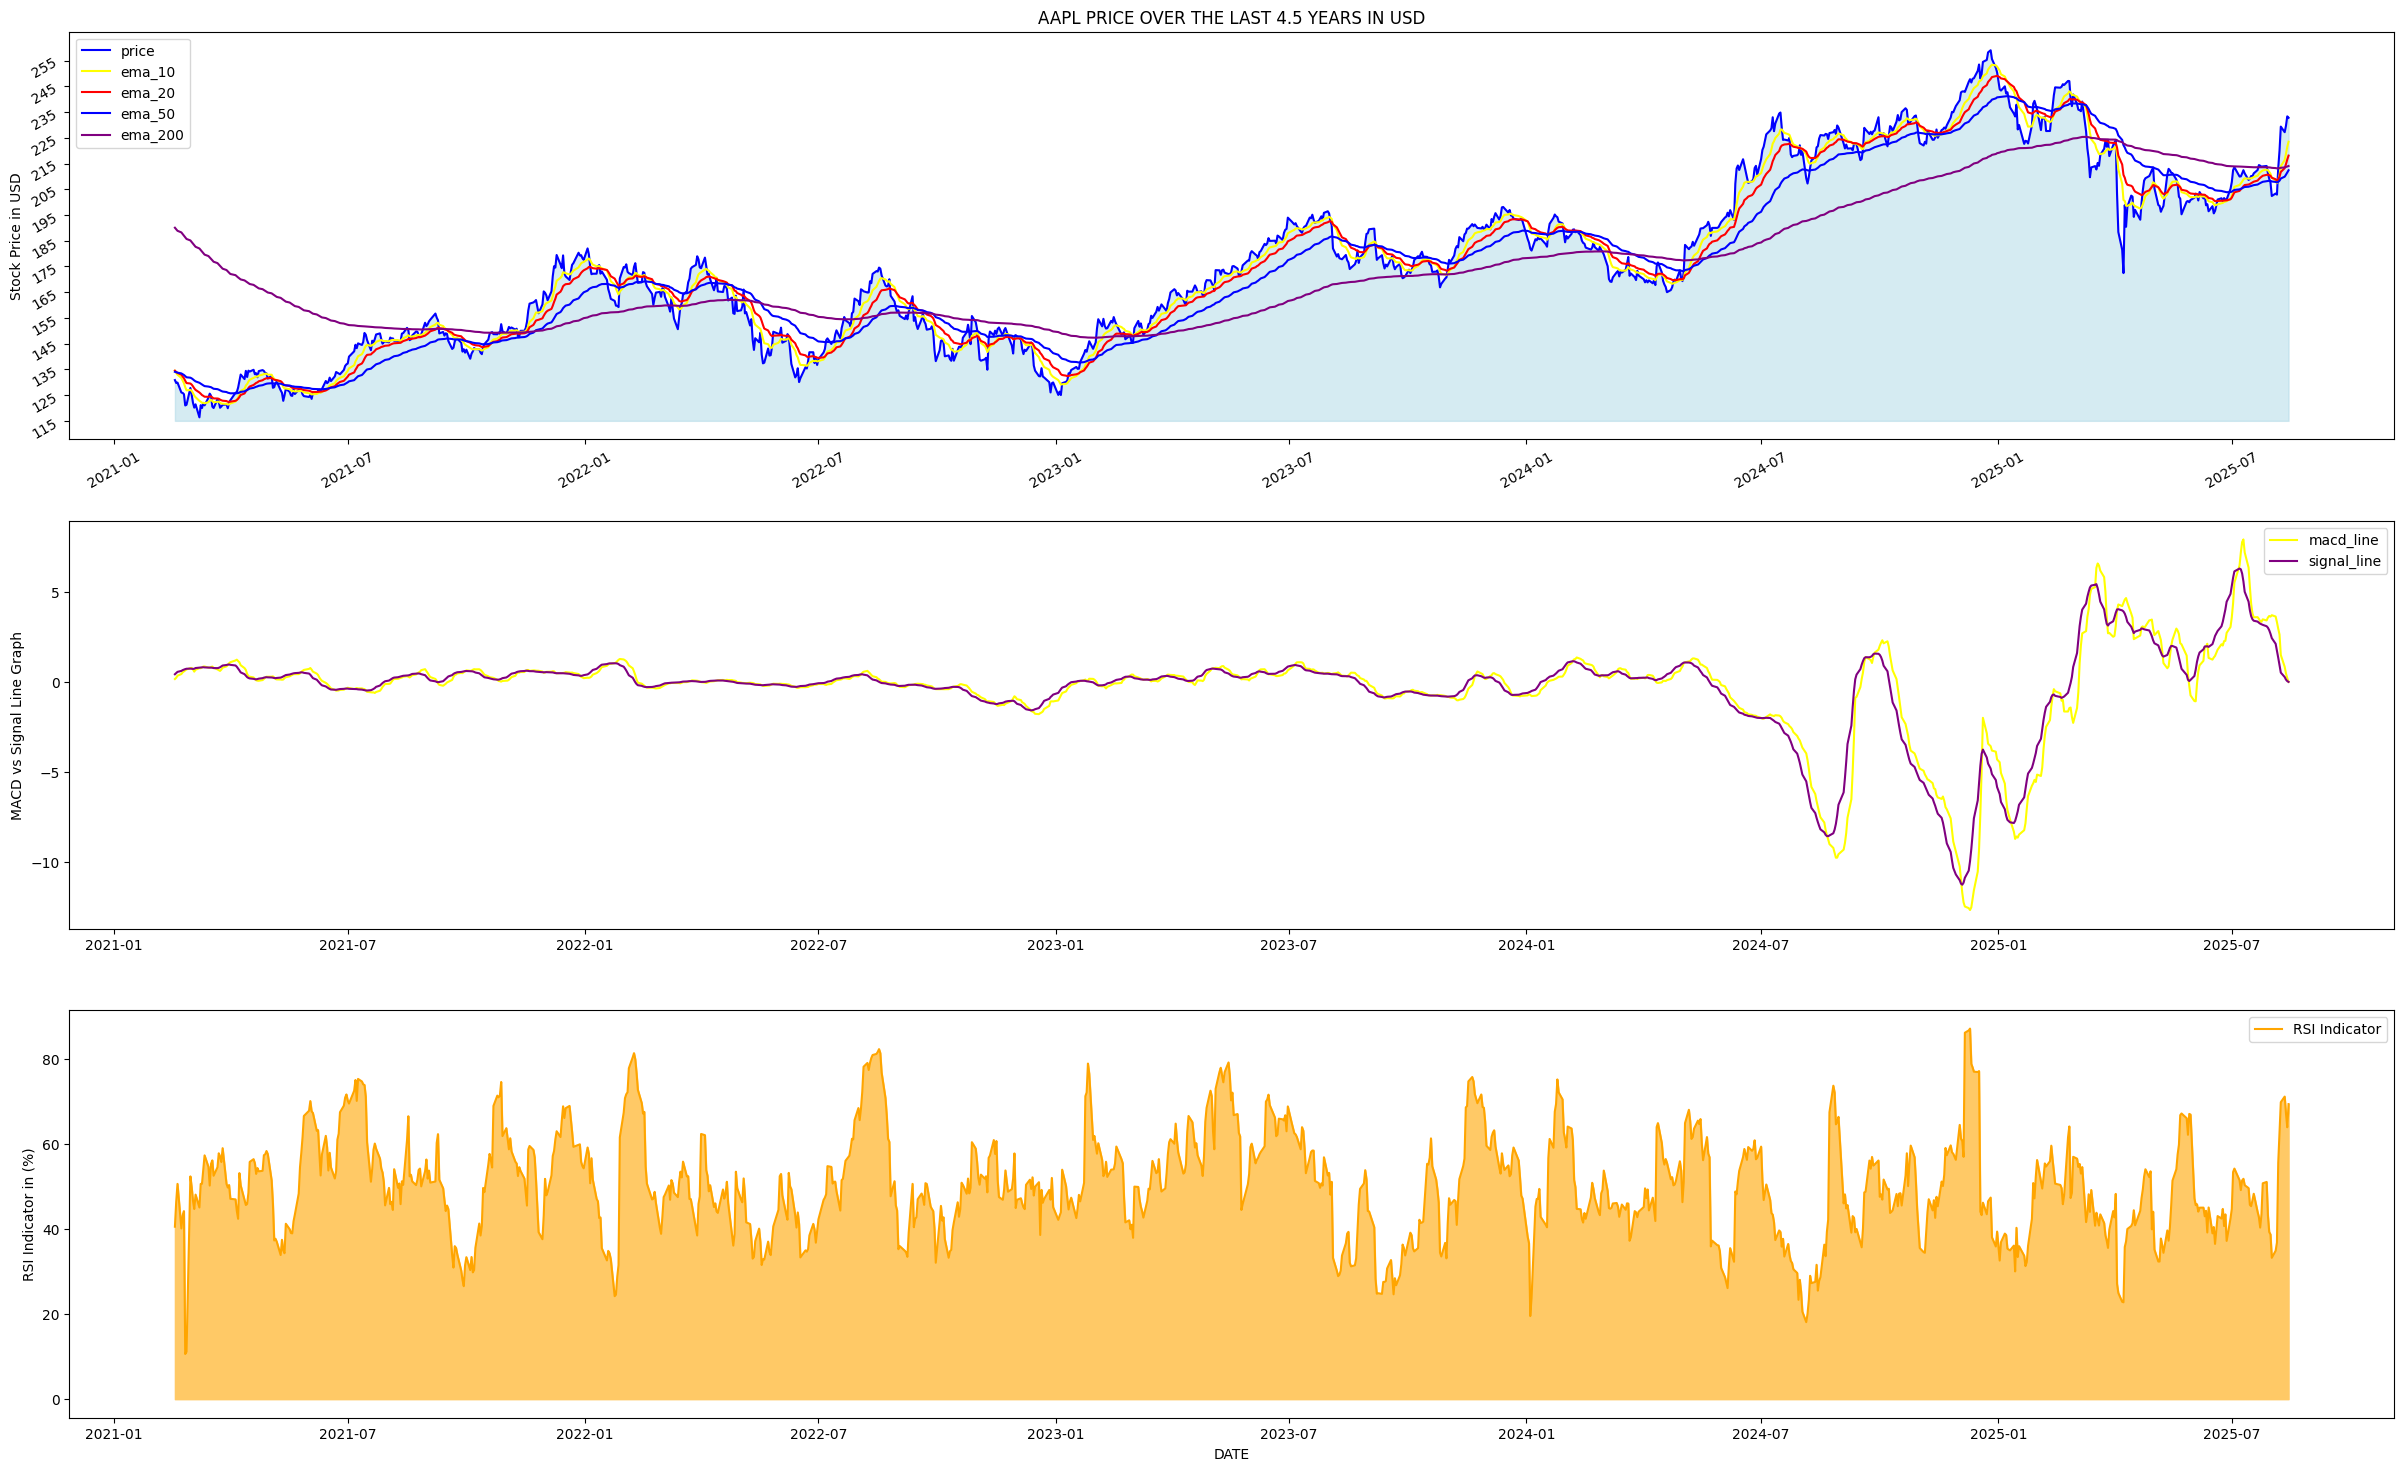

In [266]:
draw_symbol_price_history(ticker_obj = aapl_ticker, 
                          ema_history = ema_history, 
                          macd_list = macd_list, 
                          signal_line = signal_line_history,
                         rsi_list = rsi_list
                         )

## 3. Develop a stochastic model class based on data and chart analysis.

In [306]:
from datetime import datetime, timedelta
import copy 

class StochasticModel():

    def __init__(self, closing_prices: list, dates_list: list, last_n_years: int):
        self.last_n_years = last_n_years
        self.dates_list = dates_list[::-1]
        self.closing_prices = closing_prices
        self.stock_days_per_year = 252
        self.growth_drift = None
        self.volatility = None
        self.growth_drift_daily = None
        self.volatility_daily = None

        self.monte_carlo_dates = []
        self.monte_carlo_prices = []
        
        self.set_parameters()
        
    def set_parameters(self):
        """
            Use GBM equations to model the stock price using stochastic calculus.
            Use Ito's Lemma to model the log of the model for easier and simpler calculations while finding a closed form for mu and sigma.
        """

        self.last_n_prices = get_last_n(self.closing_prices, self.last_n_years)
        log_returns = np.zeros((self.last_n_years, self.stock_days_per_year - 1), dtype = np.float32)

        for i in range(self.last_n_years):
            window = self.last_n_prices[i * self.stock_days_per_year : (i + 1) * self.stock_days_per_year]
            

            for j in range(1, len(window)):
                
                log_returns[i][j - 1] = np.log(window[j] / window[j - 1])

        log_returns_annual = np.mean(log_returns, axis = 1) #Mean across each year
        total_mean_log_return = np.mean(log_returns_annual, axis = 0) # Mean across all the years

        log_returns_var = np.var(log_returns, axis = 1, ddof = 1) # Var across each year
        total_mean_log_var = np.mean(log_returns_var, axis = 0) # Var across all the years

        self.volatility_daily = np.sqrt(total_mean_log_var)  # std = sqrt(var) AVERAGED PER DAY
        self.growth_drift_daily = total_mean_log_return + (1 / 2 * total_mean_log_var) # growth = log_growth + 1 /2 * var AVERAGED PER DAY

        self.volatility = self.volatility_daily * np.sqrt(self.stock_days_per_year) # AVERAGED PER YEAR
        self.growth_drift = self.growth_drift_daily * self.stock_days_per_year # AVERAGED PER YEAR


    def __step_data(self, curr_price:float , days:int = 1):
        """
            Given the GBM parameters that are set before, and a curr closing price, return the next predicted closing price using stochastic equations:
            dX_t = mu * X_t * dt + sigma * X_t * dW

            where mu is the growth, sigma is the volatilty, X_t is the last stepping price, dt is the time step, and dW is the Wiener process.

            dW is going to be estimated by sqrt(dt) * normally distributed(0, 1).

            By default dt is days / TRADING_DAYS_PER_YEAR.

            Since days can be larger than 1, this is known as the Euler-Mayurama estimates.

            Args:
                curr_price (float): Represents X_t in the equation.
                days (int): Number of days to estimate in the step.

            Returns: 
                float: X_t + dX_t 


            Please note that dt is divided by the trading days per year because the parameters mu and sigma are estimated yearly and not daily.
        """

        dt = days / self.stock_days_per_year
        mu = self.growth_drift
        sigma = self.volatility
        
        growth = mu * curr_price * dt
        volatility = sigma * curr_price * np.sqrt(dt) * np.random.randn()
        delta = growth + volatility

        return curr_price + delta

    def monte_carlo(self, no_steps: int, store_results: bool = False):
        """Run Monte Carlo with the given number of steps. Each step is considered as one day

            Returns:
                tuple(list): A tuple of two lists: all dates (as datetime objects) and closing prices respectively, including the original data.
            
        """


        
        date_object_list = [datetime.strptime(date, "%Y-%m-%d") for date in self.dates_list]
        curr_data = copy.deepcopy(self.closing_prices)
        last_price = curr_data[0]
        
        for _ in range(no_steps):

            last_price = self.__step_data(last_price)
            curr_data.insert(0, last_price)
            date_object_list.append(date_object_list[-1] + timedelta(days=1))

        if store_results:
            self.monte_carlo_dates.append(date_object_list)
            self.monte_carlo_prices.append(curr_data)

        return date_object_list, curr_data

    def get_monte_carlo_results(self):
        """In case store_results in the monte carlo method is not False.... these two lists will contain the values."""
        
        return self.monte_carlo_dates, self.monte_carlo_prices
            

            
        

In [307]:
ticker_data = aapl_ticker.data_dict
full_dates = list(ticker_data['Time Series (Daily)'].keys())
closing_prices = [ticker_data['Time Series (Daily)'][day]['4. close'] for day in full_dates]
closing_prices = list(map(float, closing_prices))



stochastic_model = StochasticModel(closing_prices = closing_prices, dates_list= full_dates, last_n_years = 4)

MONTE_CARLO_PATHS = 1000 # WE WILL SIMULATE THIS NUMBER OF PATHS USING MONTE CARLOS SIMULATIONS
MONTE_CARLO_STEPS = 252 # WE WILL SIMULATE THIS NUMBER OF STEPS FOR EACH MONTE CARLO PATH (CURR ONE TRADING YEAR)

for _ in range(MONTE_CARLO_PATHS):
    stochastic_model.monte_carlo(no_steps = MONTE_CARLO_STEPS, store_results = True)


In [316]:
print("=" * 50)

print(f"{aapl_ticker.ticker} DAILY VOLATILITY: {stochastic_model.volatility_daily * 100 :.2f}%")
print(f"{aapl_ticker.ticker} ANNUAL VOLATILITY: {stochastic_model.volatility * 100: .2f}%")

print(f"{aapl_ticker.ticker} DAILY GROWTH: {stochastic_model.growth_drift_daily * 100:.2f} %")
print(f"{aapl_ticker.ticker} ANNUAL GROWTH: {stochastic_model.growth_drift * 100: .2f}%")

print("=" * 50)

AAPL DAILY VOLATILITY: 1.81%
AAPL ANNUAL VOLATILITY:  28.67%
AAPL DAILY GROWTH: 0.06 %
AAPL ANNUAL GROWTH:  15.36%


## 4. Run multiple Monte Carlo simulations using the stochastic model and perform a final analysis.

Text(0.5, 1.0, 'SIMULATED AAPL USING MONTE CARLO AFTER ONE YEAR')

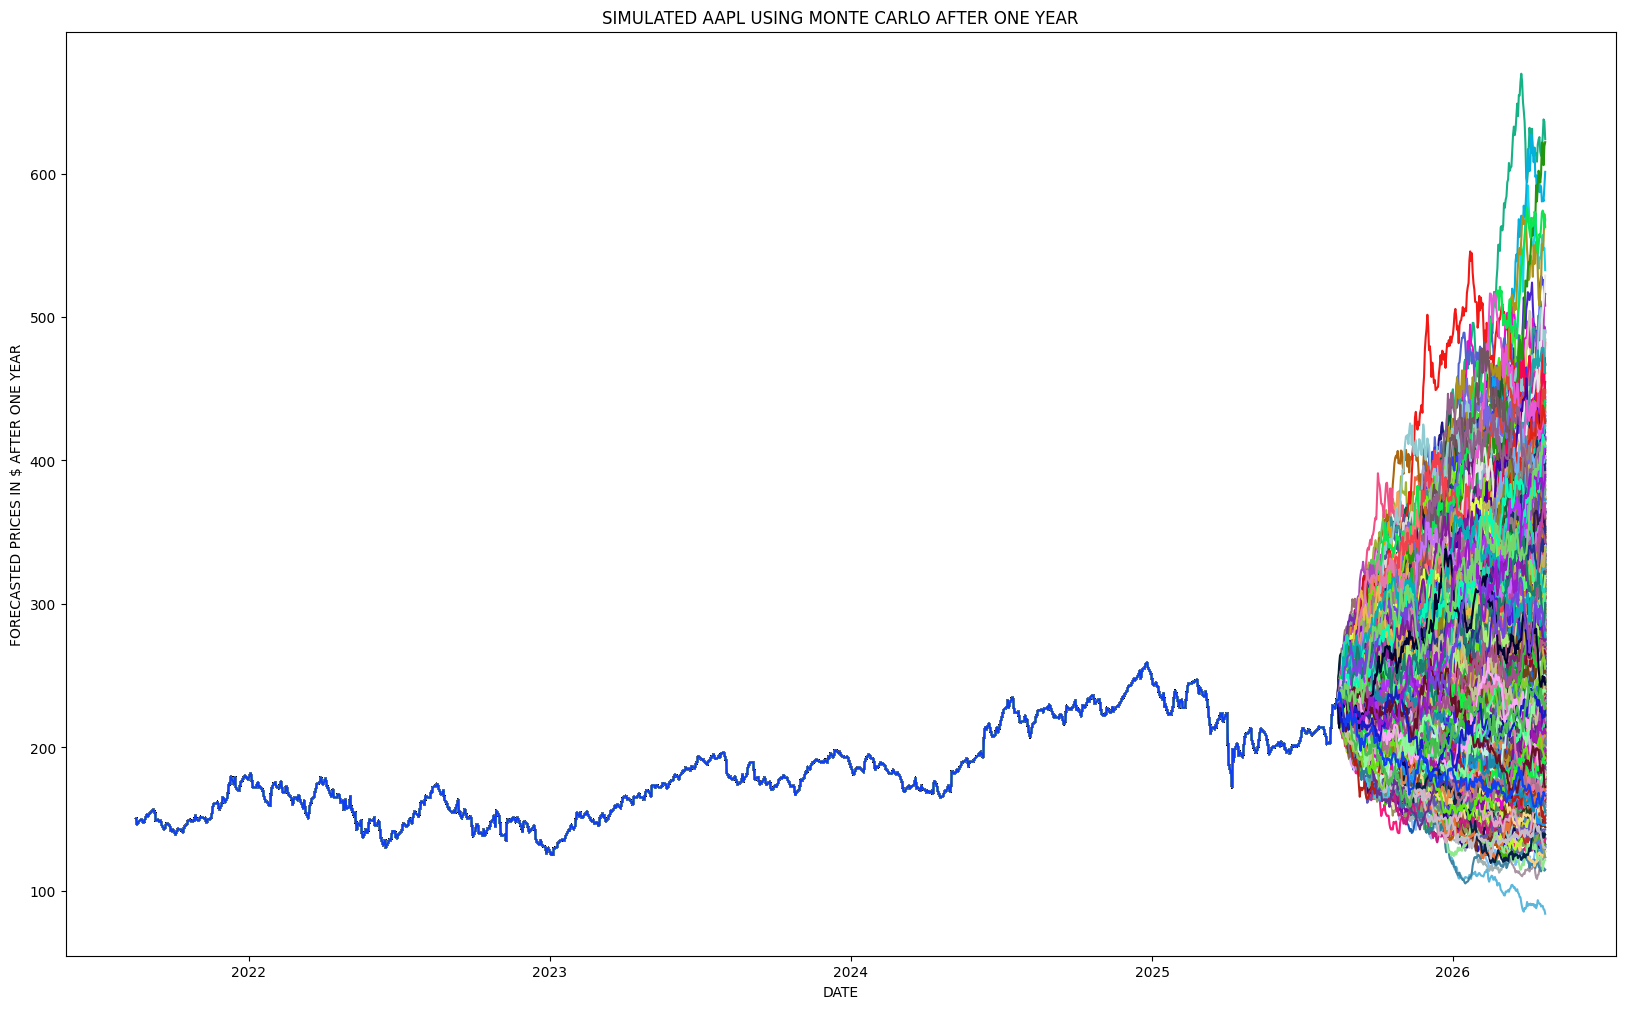

In [319]:


def generate_random_hex_color():
    """return string in the format : #HEX1_HEX2_HEX3_HEX4_HEX5_HEX6"""
    hex_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f']

    hex_str = "#"
    for i in range(6):
        hex_str += hex_list[np.random.randint(0, 16)]
    return hex_str


colors = [generate_random_hex_color() for _ in range(MONTE_CARLO_PATHS)]

simulated_dates, simulated_prices = stochastic_model.get_monte_carlo_results()

fig, ax = plt.subplots(figsize = (20, 12))

LAST_N_YEARS_MC = 5
dates = get_last_n(simulated_dates[0][::-1], LAST_N_YEARS_MC)


for i in range(MONTE_CARLO_PATHS):

    prices = get_last_n(simulated_prices[i], LAST_N_YEARS_MC)
    ax.plot(dates, prices, color = colors[i])

ax.set_xlabel("DATE")
ax.set_ylabel("FORECASTED PRICES IN $ AFTER ONE YEAR")
ax.set_title(f"SIMULATED {aapl_ticker.ticker} USING MONTE CARLO AFTER ONE YEAR")

In [323]:
last_simulated_prices = [simulated_prices[i][0] for i in range(MONTE_CARLO_PATHS)]

Text(0.5, 1.0, 'FREQUENCY PLOT OF AAPL PRICES ONE YEAR FROM NOW')

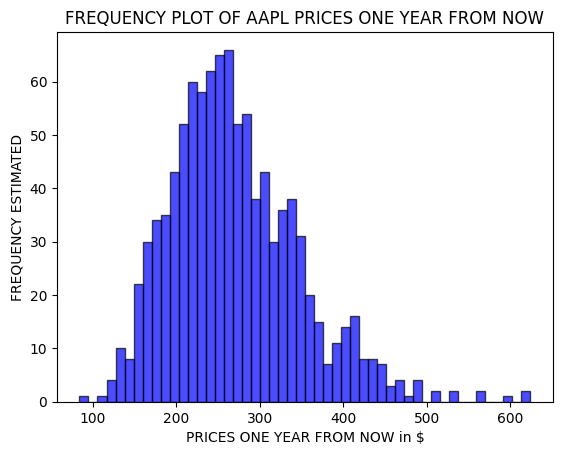

In [328]:
plt.hist(last_simulated_prices, bins = 50, color = 'blue', edgecolor = 'black', alpha = 0.7)
plt.xlabel("PRICES ONE YEAR FROM NOW in $")
plt.ylabel("FREQUENCY ESTIMATED")
plt.title(f"FREQUENCY PLOT OF {aapl_ticker.ticker} PRICES ONE YEAR FROM NOW")

In [335]:
mean_last_prices = np.mean(last_simulated_prices)
std_last_prices = np.std(last_simulated_prices)
S_P_500_ANNUAL_GROWTH = 0.12
AAPL_TODAY = 232.78
FORECASTED_GROWTH = (mean_last_prices - AAPL_TODAY) / AAPL_TODAY * 100
STD_PERCENT = std_last_prices / AAPL_TODAY * 100


print("=" * 100)

print("CURR INFLATION: 3%")
print(f"FORECASTED SHARPE RATIO OF {aapl_ticker.ticker}: {(FORECASTED_GROWTH - 3) / STD_PERCENT: .2f}")
print("S&P 500 1-YEAR SHARPE RATIO: 0.87")

print()

print(f"MEAN ESTIMATED PRICE ONE YEAR FROM NOW: {mean_last_prices: .2f}")
print(f"ESTIMATED STANDARD DEV. IN SIMULATED PATHS: {std_last_prices: .2f}")
print(f"FORECASTED GROWTH FROM TODAY: {FORECASTED_GROWTH:.2f}%")
print(f"EXPECTED ALPHA GAINED: {FORECASTED_GROWTH - S_P_500_ANNUAL_GROWTH * 100:.2f}%")
print()

print(f"MEAN + 1 STANDARD DEV. ESTIMATED PRICE ONE YEAR FROM NOW: {mean_last_prices + std_last_prices: .2f}")
print(f"MEAN + 2 STANDARD DEV. ESTIMATED PRICE ONE YEAR FROM NOW: {mean_last_prices + 2 * std_last_prices: .2f}")

print(f"MEAN - 1 STANDARD DEV. ESTIMATED PRICE ONE YEAR FROM NOW: {mean_last_prices - std_last_prices: .2f}")
print(f"MEAN - 2 STANDARD DEV. ESTIMATED PRICE ONE YEAR FROM NOW: {mean_last_prices - 2 * std_last_prices: .2f}")

print("=" * 100)

CURR INFLATION: 3%
FORECASTED SHARPE RATIO OF AAPL:  0.39
S&P 500 1-YEAR SHARPE RATIO: 0.87

MEAN ESTIMATED PRICE ONE YEAR FROM NOW:  269.95
ESTIMATED STANDARD DEV. IN SIMULATED PATHS:  77.97
FORECASTED GROWTH FROM TODAY: 15.97%
EXPECTED ALPHA GAINED: 3.97%

MEAN + 1 STANDARD DEV. ESTIMATED PRICE ONE YEAR FROM NOW:  347.92
MEAN + 2 STANDARD DEV. ESTIMATED PRICE ONE YEAR FROM NOW:  425.88
MEAN - 1 STANDARD DEV. ESTIMATED PRICE ONE YEAR FROM NOW:  191.99
MEAN - 2 STANDARD DEV. ESTIMATED PRICE ONE YEAR FROM NOW:  114.02
